# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
from nltk.tokenize import word_tokenize
import seaborn as sns



In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/evachow/Documents/GitHub/ADS509/ADS509_Module_6/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
# note: these folders were copied over to keep everything within a module 6 subfolder
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
# this will take largely from assignment 3.1
# note that the original mychemicalromance and missy lyric pulls
# didn't include the song title
# my workaround is to have the title be the txt file name as it includes the title in it

In [5]:
# define our unique artists
artist = ['mychemicalromance', 'missy']

# define the path (define the lyric folder then the folder for each artist)
path_lyrics = data_location + lyrics_folder

# see https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
path_lyrics_artist = [f for f in os.listdir(path_lyrics) if not f.startswith('.')]

# let's append artist, song, and lyrics of each song
singer = [] # defined as singer because will probably use artist for loops later
song = [] # DON'T FORGET THAT THIS (SINGULAR) IS A LIST
lyric = []

# first, a loop to go through each artist
for artist in path_lyrics_artist:
    unique_artist = path_lyrics + '/' + artist
    unique_song = os.listdir(unique_artist)
    
    # now a loop to go through each artist's song
    for music in unique_song:
        path_songs = unique_artist + '/' + music
        # see https://www.adamsmith.haus/python/answers/how-to-read-a-text-file-into-a-list-in-python
        with open(path_songs) as the_path:
            the_songs = the_path.readlines()
            
        singer.append(artist)
        song.append(music)
        lyric.append(''.join(the_songs[1:]))

In [6]:
# dataframe to check read in
headers = {'artist': singer,
           'title': song,
          'lyric': lyric}
lyrics_data = pd.DataFrame(headers)
lyrics_data.sample(5)

,artist,title,lyric
34,mychemicalromance,mychemicalromance_welcometotheblackparade.txt,"\n\n\nWhen I was a young boy, my father\nTook ..."
2,mychemicalromance,mychemicalromance_knivessorrowdemo.txt,\n\n\nWe could be perfect one last night\nAnd ...
45,mychemicalromance,mychemicalromance_goodnitedrdeath.txt,"\n\n\nAlright, children\nThe lights are out an..."
9,mychemicalromance,mychemicalromance_theend.txt,"\n\n\nNow, come one, come all to this tragic a..."
157,missy,missymisdemeanorelliott_busarhyme.txt,\n\n\n[Missy] Slim Shady [4X]\n\n[Eminem]\nWel...


In [7]:
# remove \n or tabs that have appeared
# let's check by taking any random 5 observations
lyrics_data = lyrics_data.replace(r'\n', ' ', regex=True)
lyrics_data.sample(5)

,artist,title,lyric
198,missy,missymisdemeanorelliott_imtalkin.txt,"[Verse One:] Nigga, waz up? You think you ..."
4,mychemicalromance,mychemicalromance_sleep.txt,"""They're, they're these terrors, and it's l..."
186,missy,missymisdemeanorelliott_swatdatfly.txt,Swat Swat dat fly Go head and just swat Sw...
140,missy,missymisdemeanorelliott_soaddictive.txt,[Missy - singing] I know some of y'all sick...
37,mychemicalromance,mychemicalromance_blood.txt,"Well, they encourage your complete cooperat..."


In [8]:
# Read in the twitter data
# once again, this will take largely from assignment 3.1

In [9]:
# we only need the descriptions, will use pandas
mcr_twitter = pd.read_csv('/Users/evachow/Documents/GitHub/ADS509/ADS509_Module_6/twitter/MCRofficial_followers.txt',
                          sep='\t+',
                          lineterminator='\n', # added because couldn't parse end of line tabs
                          error_bad_lines=False) # some lines saw additional fields; this ignores those rows)

/var/folders/vc/ts8zgw4j4sbf_4rwblbwxrf40000gn/T/ipykernel_78637/4156461855.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mcr_twitter = pd.read_csv('/Users/evachow/Documents/GitHub/ADS509/ADS509_Module_6/twitter/MCRofficial_followers.txt',
/var/folders/vc/ts8zgw4j4sbf_4rwblbwxrf40000gn/T/ipykernel_78637/4156461855.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  mcr_twitter = pd.read_csv('/Users/evachow/Documents/GitHub/ADS509/ADS509_Module_6/twitter/MCRofficial_followers.txt',
Skipping line 77481: Expected 7 fields in line 77481, saw 8. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 78691: Expected 7 fields in line 78691, saw 8. Error c

In [10]:
# let's get only the descriptions
mcr_twitter['artist'] = 'mychemicalromance'
mcr_twitter = mcr_twitter[['artist', 'description']]
mcr_twitter.sample(5)

,artist,description
45963,mychemicalromance,Twitch - https://t.co/9l6uXDSMuJ ||||||||||| Y...
98082,mychemicalromance,None
97837,mychemicalromance,None
106051,mychemicalromance,None
56592,mychemicalromance,None


In [11]:
# and now the robyn data
missy_twitter = pd.read_csv('/Users/evachow/Documents/GitHub/ADS509/ADS509_Module_6/twitter/MissyElliott_followers.txt',
                            sep='\t+',
                            lineterminator='\n', # added because couldn't parse end of line tabs
                            error_bad_lines=False) # some lines saw additional fields; this ignores those rows)sep='\t+')
missy_twitter['artist'] = 'missy'
missy_twitter = missy_twitter[['artist', 'description']]
missy_twitter.sample(5)

/var/folders/vc/ts8zgw4j4sbf_4rwblbwxrf40000gn/T/ipykernel_78637/3311687236.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  missy_twitter = pd.read_csv('/Users/evachow/Documents/GitHub/ADS509/ADS509_Module_6/twitter/MissyElliott_followers.txt',
/var/folders/vc/ts8zgw4j4sbf_4rwblbwxrf40000gn/T/ipykernel_78637/3311687236.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  missy_twitter = pd.read_csv('/Users/evachow/Documents/GitHub/ADS509/ADS509_Module_6/twitter/MissyElliott_followers.txt',
Skipping line 67568: Expected 7 fields in line 67568, saw 8. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


,artist,description
84166,missy,fan of @flolikethis stream cardboard box 📦 #FL...
45642,missy,None
88,missy,Sweetness
96302,missy,None
76059,missy,None


In [12]:
# using pandas, concatenate both twitter dataframes into one
dataframes = [mcr_twitter, missy_twitter]
twitter = pd.concat(dataframes)
twitter.sample(10)

,artist,description
111826,mychemicalromance,transbian! nsfw dni! priv is @rachaelbutalt
3516,missy,None
104838,mychemicalromance,None
19290,mychemicalromance,None
62804,mychemicalromance,The rest is rust and stardust
69153,missy,None
44678,missy,None
55933,missy,"""Bem humorado, critico e auto critico"
78606,missy,None
73393,mychemicalromance,None


In [13]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.
positive = pd.read_csv(data_location + positive_words_file, sep='\t', encoding='latin-1')
negative = pd.read_csv(data_location + negative_words_file, sep='\t', encoding='latin-1')
tidytext_sentiment = pd.read_csv(data_location + tidy_text_file, sep='\t')

# encoding specification added to eliminate the following error
# UnicodeDecodeError, invalid continuation byte

In [14]:
positive.head(50); negative.head(50)

,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
0,;
1,; Opinion Lexicon: Negative
2,;
3,; This file contains a list of NEGATIVE opinio...
4,;
5,; This file and the papers can all be download...
6,; http://www.cs.uic.edu/~liub/FBS/sentiment...
7,;
8,"; If you use this list, please cite one of the..."
9,;


In [15]:
# seeing the first 50 samples, note how positive and negative words don't begin until after 33 observations
positive = positive[33:]
negative = negative[33:]
positive.head()

,;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
33,a+
34,abound
35,abounds
36,abundance
37,abundant


In [16]:
# now let's add the scores
positive['score'] = +1
negative['score'] = -1

In [17]:
# let's name the columns
positive.columns = ['word', 'score']
negative.columns = ['word', 'score']

In [18]:
positive.head()

,word,score
33,a+,1
34,abound,1
35,abounds,1
36,abundance,1
37,abundant,1


In [19]:
# after dropping the first 33 of both positive and negative words, let's look at tidytext
tidytext_sentiment.head()

,word,sentiment,lexicon
0,abandon,negative,nrc
1,abandoned,negative,nrc
2,abandonment,negative,nrc
3,abba,positive,nrc
4,abduction,negative,nrc


In [20]:
# now let's associate tidytext scores based on sentiment
tidytext_sentiment['score'] = np.where(tidytext_sentiment['sentiment'] == 'positive', +1, -1)
tidytext_sentiment.head()

,word,sentiment,lexicon,score
0,abandon,negative,nrc,-1
1,abandoned,negative,nrc,-1
2,abandonment,negative,nrc,-1
3,abba,positive,nrc,1
4,abduction,negative,nrc,-1


In [21]:
print('The number of words in positive is ',len(positive));
print('The number of words in negative is ',len(negative));
print('The number of words in tidytext_sentiment is ',len(tidytext_sentiment))

The number of words in positive is  2006
The number of words in negative is  4783
The number of words in tidytext_sentiment is  15133


In [22]:
# let's combine all three dataframes
# first, let's only include columns we want from tidytext_sentiment
tidytext_sentiment = tidytext_sentiment[['word', 'score']]

In [23]:
# let's use pandas to concatenate and drop duplicate entries
# see https://stackoverflow.com/questions/21317384/how-to-concatenate-two-dataframes-without-duplicates
combo_lex = pd.concat([positive, negative, tidytext_sentiment]).drop_duplicates().reset_index(drop=True)

In [24]:
print('The number of words in the combined lexicon is ',len(combo_lex));

The number of words in the combined lexicon is  11539


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [25]:
# your code here
# let's properly break down the song lyrics into their tokens
# the following takes largely from previous modules with some modifications
# this will be our clean up pipeline

punctuation = set(punctuation) # a set of all punctuation
whitespace = re.compile(r"\s+") # regex to ID whitespace; not necessary because of hashtags
sw = set(stopwords.words("english")) # define the stopwords

# the following is taken from previous Module assignments with minor adjustments
# see https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
def remove_stop(tokens) :
    # modify this function to remove stopwords
    return[w for w in tokens if w not in sw]

def remove_punctuation(text, punct_set=punctuation) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) :
    # we'll have it return i, where i = tokens
    return(i for i in whitespace.split(text))

def prepare(text, pipeline) : 
    tokens = str(text)
    for transform in pipeline : 
        tokens = transform(tokens)    
    return(tokens)

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

In [26]:
# the following takes from blueprints for text analytics using python page 301
# this is the pipeline to generate a sentiment score

def sent_score(text):
    sentiment_score = 0
    for word in text:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(text)

In [27]:
# let's create our dictionary of sentiments
# see https://cmdlinetips.com/2021/04/convert-two-column-values-from-pandas-dataframe-to-a-dictionary/
# to quick convert df to dict
word_dict = dict(zip(combo_lex.word, combo_lex.score))

In [28]:
# let's get the tokens of our lyrics
lyrics_data['tokens'] = lyrics_data['lyric'].apply(prepare, pipeline=my_pipeline)

# now let's get our sentiment scores
lyrics_data['sentiment_score'] = lyrics_data['tokens'].apply(sent_score)

In [29]:
lyrics_data.head()

,artist,title,lyric,tokens,sentiment_score
0,mychemicalromance,mychemicalromance_bulletproofheart.txt,Gravity don't mean too much to me I'm who I...,"[, gravity, dont, mean, much, im, ive, got, pi...",0.088496
1,mychemicalromance,mychemicalromance_thisisthebestdayever.txt,And we can run from the backdrop of these g...,"[, run, backdrop, gears, scalpels, every, hour...",0.056604
2,mychemicalromance,mychemicalromance_knivessorrowdemo.txt,We could be perfect one last night And die ...,"[, could, perfect, one, last, night, die, like...",-0.137615
3,mychemicalromance,mychemicalromance_skylinesandturnstiles.txt,"You're not in this alone, let me break this...","[, youre, alone, let, break, awkward, silence,...",0.019737
4,mychemicalromance,mychemicalromance_sleep.txt,"""They're, they're these terrors, and it's l...","[, theyre, theyre, terrors, like, feels, like,...",-0.014218


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

In [30]:
lyrics_data.groupby(['artist'])['sentiment_score'].mean()

artist
missy                0.028622
mychemicalromance   -0.016581
Name: sentiment_score, dtype: float64

A: Overall, Missy Elliott has the higher average sentiment per song. This largely makes sense considering that My Chemical Romance writes songs that fall consistently in the pop punk genre, or "emo music". This type of music was known to be overly emotional and could be dark in topic and therefore seems more likely to contain lyrics with words that have a negative sentiment score.
___

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

In [31]:
missy_lyrics = lyrics_data[lyrics_data['artist']=='missy']
missy_lyrics.nlargest(5, 'sentiment_score')

,artist,title,lyric,tokens,sentiment_score
164,missy,missymisdemeanorelliott_itsreal.txt,"[Intro] Yeah, ohhh-ohh Yeaahhh, yeaaa I lov...","[, intro, yeah, ohhhohh, yeaahhh, yeaaa, love,...",0.333333
190,missy,missymisdemeanorelliott_xtasy.txt,"[Missy] Read between the lines Ecstacy, a p...","[, missy, read, lines, ecstacy, place, fullfil...",0.206897
176,missy,missymisdemeanorelliott_bestfriends.txt,[VERSE 1:] My best friend say She sick of...,"[, verse, 1, best, friend, say, sick, cryin, p...",0.166667
213,missy,missymisdemeanorelliott_cooloff.txt,"This is a Missy Elliott exclusive Do it, ...","[, missy, elliott, exclusive, get, get, get, g...",0.162037
225,missy,missymisdemeanorelliott_stepoff.txt,I know your not my man That you belong to s...,"[, know, man, belong, someone, else, nah, come...",0.152672


In [32]:
missy_lyrics.nsmallest(5, 'sentiment_score')

,artist,title,lyric,tokens,sentiment_score
217,missy,missymisdemeanorelliott_hot.txt,[Missy] This is an old school Missy exclusi...,"[, missy, old, school, missy, exclusive, verse...",-0.136076
159,missy,missymisdemeanorelliott_wedidit.txt,"We made love, now you gone Now you don't wa...","[, made, love, gone, dont, wanna, claim, told,...",-0.106667
154,missy,missymisdemeanorelliott_geturfreakon.txt,"hit me, hit me gimme some new shit gimme ...","[, hit, hit, gimme, new, shit, gimme, new, shi...",-0.102564
104,missy,missymisdemeanorelliott_joy.txt,[1:36 long skit precedes the actual song] ...,"[, 136, long, skit, precedes, actual, song, el...",-0.084158
140,missy,missymisdemeanorelliott_soaddictive.txt,[Missy - singing] I know some of y'all sick...,"[, missy, singing, know, yall, sick, songs, ya...",-0.077778


A: The top and bottom five Missy Elliott songs by sentiment were printed. The song with the highest for Missy was "It's Real", and the lowest for Missy was "Hot".
___

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

In [33]:
mcr_lyrics = lyrics_data[lyrics_data['artist']=='mychemicalromance']
mcr_lyrics.nlargest(5, 'sentiment_score')

,artist,title,lyric,tokens,sentiment_score
95,mychemicalromance,mychemicalromance_everysnowflakeisdifferent.txt,Every snowflake's different just like you (...,"[, every, snowflakes, different, like, every, ...",0.213333
66,mychemicalromance,mychemicalromance_sing.txt,"Sing it out, boy, you've got to see what to...","[, sing, boy, youve, got, see, tomorrow, bring...",0.169903
7,mychemicalromance,mychemicalromance_stayuntitled.txt,"Say, the lights are really low enough to pl...","[, say, lights, really, low, enough, play, cat...",0.166667
39,mychemicalromance,mychemicalromance_theonlyhopeformeisyou.txt,"(Remember me, remember me) Remember me, rem...","[, remember, remember, remember, remember, rem...",0.143939
35,mychemicalromance,mychemicalromance_inevertoldyouwhatidoforalivi...,Far from this return I fall out of grace I ...,"[, far, return, fall, grace, gave, whole, life...",0.137255


In [34]:
mcr_lyrics.nsmallest(5, 'sentiment_score')

,artist,title,lyric,tokens,sentiment_score
63,mychemicalromance,mychemicalromance_teenagers.txt,They're gonna clean up your looks with all ...,"[, theyre, gonna, clean, looks, lies, books, m...",-0.265432
54,mychemicalromance,mychemicalromance_cemeterydrive.txt,"This night, walk the dead In a solitary sty...","[, night, walk, dead, solitary, style, crash, ...",-0.214286
71,mychemicalromance,mychemicalromance_mastasofravenkroft.txt,Salutations From a greater northwest alley ...,"[, salutations, greater, northwest, alley, res...",-0.186047
46,mychemicalromance,mychemicalromance_ourladyofsorrows.txt,We could be perfect one last night And die ...,"[, could, perfect, one, last, night, die, like...",-0.149533
2,mychemicalromance,mychemicalromance_knivessorrowdemo.txt,We could be perfect one last night And die ...,"[, could, perfect, one, last, night, die, like...",-0.137615


A: The top and bottom five My Chemical Romance songs were printed. The song with the highest score for My Chemical Romance is "Every Snowflake is Different", and the lowest for My Chemical Romance is "Teenagers".
___

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

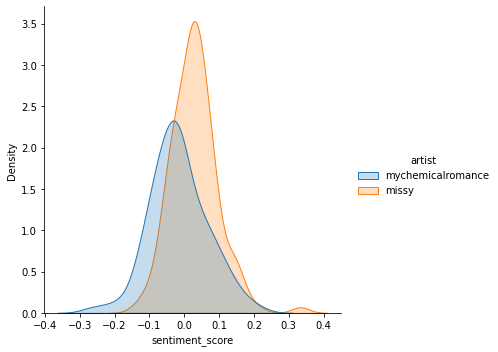

In [35]:
sns.displot(lyrics_data, x='sentiment_score', hue='artist', kind='kde', fill=True)

A: The seaborn density plot is displayed above. As suspected, Missy Elliott songs tend to have a higher sentiment score compared to My Chemical Romance songs.
___

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [36]:
# your code here
# we'll take the emoji sentiment data from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0144296
emojis = pd.read_csv('/Users/evachow/Documents/GitHub/ADS509/ADS509_Module_6/Emoji_Sentiment_Data_v1.0.csv')
emojis.head()

,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block
0,😂,0x1f602,14622,0.805101,3614,4163,6845,FACE WITH TEARS OF JOY,Emoticons
1,❤,0x2764,8050,0.746943,355,1334,6361,HEAVY BLACK HEART,Dingbats
2,♥,0x2665,7144,0.753806,252,1942,4950,BLACK HEART SUIT,Miscellaneous Symbols
3,😍,0x1f60d,6359,0.765292,329,1390,4640,SMILING FACE WITH HEART-SHAPED EYES,Emoticons
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,LOUDLY CRYING FACE,Emoticons


In [37]:
# similar to the word dictionary, let's associate the emojis based on the highest ranking "sentiment
# we'll drop the "Neutral" sentiment
emojis = emojis.drop(columns=['Unicode codepoint', 'Occurrences', 'Position', 'Neutral', 'Unicode name', 'Unicode block'])

In [38]:
emojis['sentiment'] = emojis[['Negative', 'Positive']].idxmax(axis=1)

In [39]:
emojis.head()

,Emoji,Negative,Positive,sentiment
0,😂,3614,6845,Positive
1,❤,355,6361,Positive
2,♥,252,4950,Positive
3,😍,329,4640,Positive
4,😭,2412,1896,Negative


In [40]:
# now let's narrow this to just our score and emoji
emojis['score'] = np.where(emojis['sentiment'] == 'Positive', +1, -1)
emojis.head()

,Emoji,Negative,Positive,sentiment,score
0,😂,3614,6845,Positive,1
1,❤,355,6361,Positive,1
2,♥,252,4950,Positive,1
3,😍,329,4640,Positive,1
4,😭,2412,1896,Negative,-1


In [41]:
# now let's drop everything we don't need and rename our columns
emojis = emojis.drop(columns=['Negative', 'Positive', 'sentiment'])
emojis.columns = ['word', 'score']
emojis.head()

,word,score
0,😂,1
1,❤,1
2,♥,1
3,😍,1
4,😭,-1


In [42]:
# let's define a new function to get sentiment score of emojis + words
def senti_score(text):
    word_base_score = 0
    for word in text:
        if word in new_dict:
            word_base_score += new_dict[word]
    return word_base_score / (len(text) or not len(text))

In [43]:
# now let's define our emoji in a dictionary
emoji_dict = dict(zip(emojis.word, emojis.score))

In [44]:
# we'll combine our word and emoji dictionaries together for our function
def Merge(dict1, dict2):
    for i in dict2.keys():
        dict1[i]=dict2[i]
    return dict1

new_dict = Merge(word_dict, emoji_dict)

In [45]:
# let's get the tokens of our twitter data cleaned up
twitter['tokens'] = twitter['description'].apply(prepare, pipeline=my_pipeline)

# now let's get our sentiment scores
twitter['sentiment_score'] = twitter['tokens'].apply(senti_score)

In [46]:
# we don't need to see THIS much info, but we can tell that emojis placed next to another or immediately
# adjacent to a word negates the emoji score
# with more time, this could be troubleshot
twitter.sample(20)

,artist,description,tokens,sentiment_score
91714,missy,"humble, father, son, friend,thinker, human","[humble, father, son, friendthinker, human]",-0.20
38386,missy,None,[none],0.00
112952,missy,None,[none],0.00
103087,missy,None,[none],0.00
121076,mychemicalromance,None,[none],0.00
105711,missy,None,[none],0.00
12512,mychemicalromance,mornings are for coffee and contemplation | @d...,"[mornings, coffee, contemplation, dustinroley❤️]",0.25
111514,mychemicalromance,Wuapo el que lo lea,"[wuapo, el, que, lo, lea]",0.00
99372,mychemicalromance,"""dear diary, today will be different💌","[dear, diary, today, different💌]",0.50
29189,missy,None,[none],0.00


___
Q: What is the average sentiment of your two artists? 

In [47]:
twitter.groupby(['artist'])['sentiment_score'].mean()

artist
missy                0.031448
mychemicalromance    0.014076
Name: sentiment_score, dtype: float64

A: The average sentiment for Missy Elliott is 0.031 and the average for My Chemical Romance is 0.014. However, we must note that because many descriptions are blank, we have a mode with a sentiment score of zero that is affecting both of these.
___

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

In [48]:
# let's define our emojis as positive or negative
positive_emojis = emojis.loc[emojis['score'] == 1]
pos_dict = dict(zip(positive_emojis.word, positive_emojis.score))

negative_emojis = emojis.loc[emojis['score']== -1]
neg_dict = dict(zip(negative_emojis.word, negative_emojis.score))

In [49]:
# let's also separate our twitter data by artist
mcr_twitter = twitter[twitter['artist']=='mychemicalromance']
missy_twitter = twitter[twitter['artist']=='missy']

In [50]:
# let's create lists of the emoji counts, positive and negative, for each artist

# My Chemical Romance
mcr_pos = []
for token in mcr_twitter['tokens']:
    for i in token:
        if i in pos_dict:
            mcr_pos.append(i)
            
mcr_neg = []
for token in mcr_twitter['tokens']:
    for i in token:
        if i in neg_dict:
            mcr_neg.append(i)
            
# Missy Elliott
missy_pos = []
for token in missy_twitter['tokens']:
    for i in token:
        if i in pos_dict:
            missy_pos.append(i)
            
missy_neg = []
for token in missy_twitter['tokens']:
    for i in token:
        if i in neg_dict:
            missy_neg.append(i)

In [51]:
# let's do print statements for the most popular positive and negative emojis for each artist
print('The most popular positive emoji amongst MCR twitter followers is', Counter(mcr_pos).most_common(1));
print('\nThe most popular negative emoji amongst MCR twitter followers is', Counter(mcr_neg).most_common(1));
print('\nThe most popular positive emoji amongst Missy Elliott twitter followers is', Counter(missy_pos).most_common(1));
print('\nThe most popular negative emoji amongst Missy Elliott twitter followers is', Counter(missy_neg).most_common(1));


The most popular positive emoji amongst MCR twitter followers is [('♡', 700)]

The most popular negative emoji amongst MCR twitter followers is [('🔞', 183)]

The most popular positive emoji amongst Missy Elliott twitter followers is [('✨', 166)]

The most popular negative emoji amongst Missy Elliott twitter followers is [('🔞', 36)]


A: See above for the printed statements of the most popular emojis.
___